# Estimating Abalone Age 

This dataset from https://archive.ics.uci.edu/dataset/1/abalone contains physical features and the number of rings on 4177 Abalone. The number of rings give a rough idea of the age of the abalone but require looking at a shell sample under a microscope. My goal is to create a machine learning model that can help predict the number of rings based on more easily measured data such as sex, diameter, length and more. 

In [138]:
# Data manipulation and visualization
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler


# Modeling 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error



### Data Import

The data I am using is from the uci machine learning repository 

In [139]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
abalone = fetch_ucirepo(id=1) 

# Get data 
X = abalone.data.features 
y = abalone.data.targets["Rings"]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

train_full = pd.concat([X_train, y_train], axis=1)

## Data Exploration

Data Overview: TODO

From this I can see most features are numeric with Sex being categorical. It also seems there are no missing values in the data. 

In [140]:
train_full.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
3906,M,0.245,0.180,0.065,0.0635,0.0245,0.0135,0.020,4
2562,I,0.440,0.325,0.100,0.4165,0.1850,0.0865,0.110,6
2197,I,0.405,0.305,0.105,0.3625,0.1565,0.0705,0.125,10
1405,M,0.655,0.535,0.205,1.6445,0.7305,0.3595,0.460,13
1903,M,0.575,0.445,0.145,0.8760,0.3795,0.1615,0.270,10


In [141]:
train_full.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000,3132.000000
mean,0.524729,0.408410,0.139799,0.829697,0.359679,0.181121,0.239315,9.948276
std,0.119612,0.098746,0.042385,0.488028,0.221254,0.109618,0.138384,3.257677
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.447500,0.188000,0.095000,0.130000,8.000000
50%,0.545000,0.425000,0.145000,0.800000,0.336250,0.171000,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.252500,0.325625,11.000000
max,0.800000,0.630000,1.130000,2.779500,1.488000,0.760000,1.005000,29.000000


### Plots

It seems that Sex does not have a large difference on age but being an infant does. 

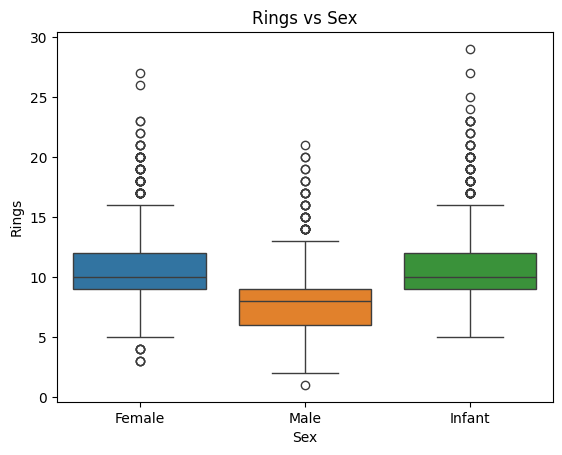

In [142]:
sns.boxplot(data=train_full, x="Sex", y="Rings", hue="Sex", legend=False)
plt.title("Rings vs Sex")
plt.xticks(ticks=[0, 1, 2], labels=["Female", "Male", "Infant"])
plt.show()

The plots for Length, Diameter, and Height all look similar. The Length plot is seen below. In addition the weight features look similar between each 

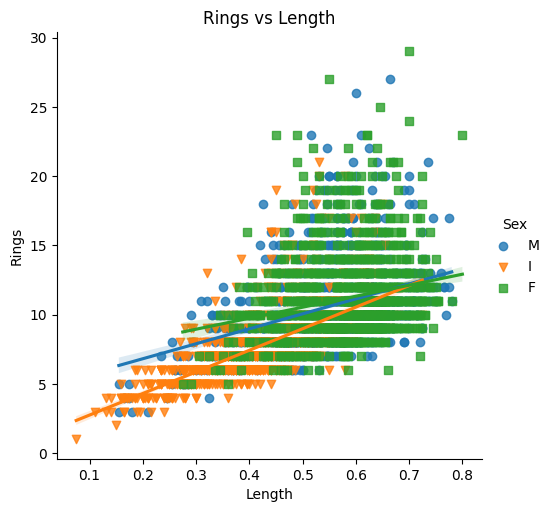

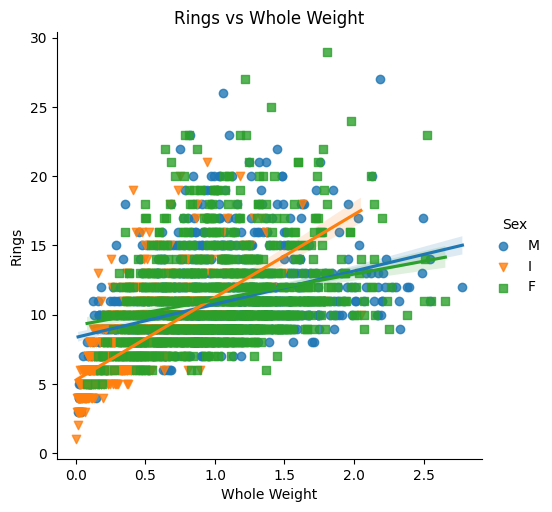

In [143]:
sns.lmplot(
    data=train_full, x="Length", y="Rings", hue="Sex", markers=["o", "v", "s"]
).set(title="Rings vs Length")
sns.lmplot(
    data=train_full, x="Whole_weight", y="Rings", hue="Sex", markers=["o", "v", "s"]
).set(title="Rings vs Whole Weight", xlabel="Whole Weight")

#### Colinearity 

Note that many of these features such as different mass or size measurements are highly correlated. This suggests I might want to use Ridge or Lasso to help with this. 

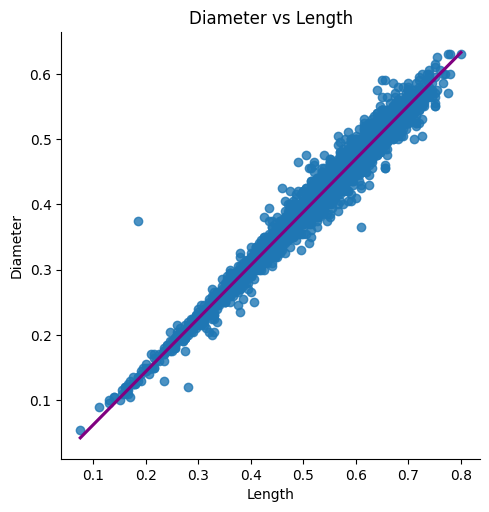

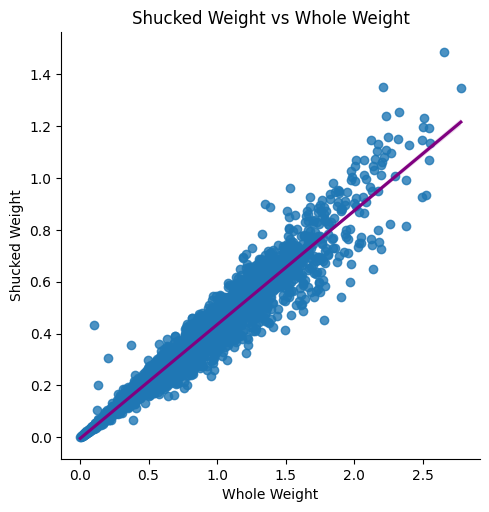

In [144]:
sns.lmplot(
    data=train_full, x="Length", y="Diameter", line_kws={"color": "purple"}
).set(title="Diameter vs Length")
sns.lmplot(
    data=train_full, x="Whole_weight", y="Shucked_weight", line_kws={"color": "purple"}
).set(title="Shucked Weight vs Whole Weight", xlabel="Whole Weight", ylabel="Shucked Weight")

### Feature Creation

The first feature I made was averaging the three length measurement. The next feature I am making is the avg_len_cubed as this is approximately proportional to the volume of the abalone. These distributions do look similar however to the length and mass feature from before. 

In [145]:
def create_features(data):
    # formula 4/3 abc pi for ellipsoid volume 
    # for half ellipsoid approx 2abc
    out = data.copy()
    out["avg_len"] = (out["Length"] + out["Diameter"] + out["Height"]) / 3
    out["avg_len_cubed"] = out["avg_len"] ** 3
    return out

train_adj = create_features(train_full)

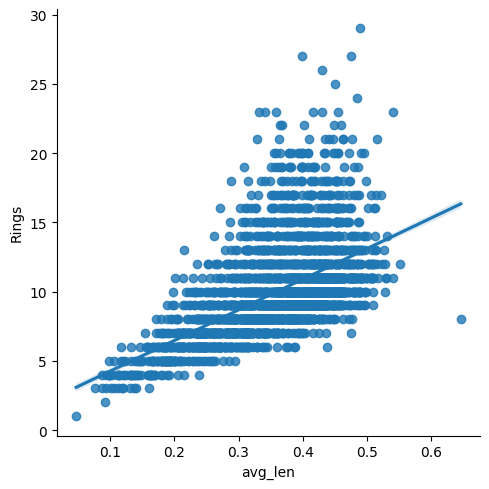

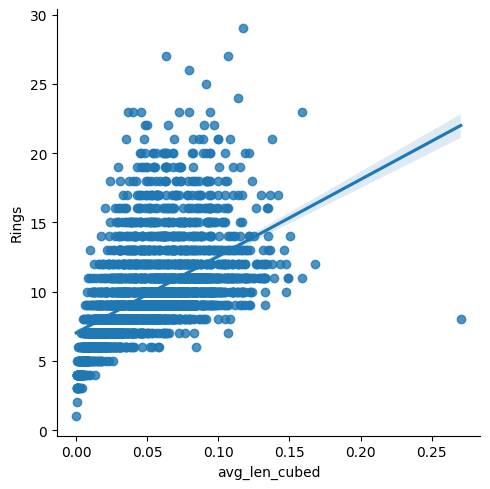

In [146]:
sns.lmplot(
    data=train_adj, x="avg_len", y="Rings"
)
sns.lmplot(
    data=train_adj, x="avg_len_cubed", y="Rings"
)


## Modeling 

I am going to use Ridge, Lasso, ElasticNet, RandomForest, and Gradient Boosting

### Scaling 

I am going to use models such as Lasso and Ridge which require standardizing features.

In [147]:
scaler = StandardScaler()

X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)


X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_dummies), 
    index=X_train_dummies.index,
    columns=X_train_dummies.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_dummies),
    index=X_test_dummies.index,
    columns=X_test_dummies.columns
)



### Ridge

In [148]:
grid = GridSearchCV(
    Ridge(),
    {"alpha": 10 ** np.arange(-10, 10.5, 0.5)}
)

grid.fit(X_train_scaled, y_train) 
ridge_model = grid.best_estimator_
print("MSE", grid.best_score_)
ridge_model

MSE 0.521351372025197


,alpha,np.float64(1.0)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


### Lasso

In [149]:
grid = GridSearchCV(
    Lasso(),
    {"alpha": 10 ** np.arange(-3, 3, 0.5)}
)

grid.fit(X_train_scaled, y_train)
lasso_model = grid.best_estimator_
print("MSE", grid.best_score_)
lasso_model


MSE 0.5215001227692548


,alpha,np.float64(0....2776601683794)
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


### Elastic Net

In [150]:
grid = GridSearchCV(
    ElasticNet(),
    {"alpha": 10 ** np.arange(-3, 3, 0.5)}
)

grid.fit(X_train_scaled, y_train)
elastic_model = grid.best_estimator_
print("MSE", grid.best_score_)
elastic_model

MSE 0.5214016321453074


,alpha,np.float64(0.001)
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


### Random Forest

In [151]:
grid = GridSearchCV(
    RandomForestRegressor(random_state=123),
    {"n_estimators": [200, 300], "max_depth": [7, 9, 11]}
)

grid.fit(X_train_scaled, y_train)
forest_model = grid.best_estimator_
print("MSE", grid.best_score_)
forest_model

MSE 0.5544722749714373


,n_estimators,300
,criterion,'squared_error'
,max_depth,9
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Gradient Boosting

In [152]:
grid = GridSearchCV(
    GradientBoostingRegressor(random_state=123, learning_rate=0.1),
    {"n_estimators": [100, 200], "max_depth": [2, 3]}
)

grid.fit(X_train_scaled, y_train)
boosting_model = grid.best_estimator_
print("MSE", grid.best_score_)
boosting_model

MSE 0.5513617077534197


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


## Testing Models